In [1]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.7 MB/s eta 0:00:00


In [2]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt
import pickle

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
from torcheval.metrics.functional import binary_auroc

# Utils
import joblib
from tqdm.auto import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold, KFold
from sklearn.metrics import roc_curve, auc, roc_auc_score

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
import optuna
import catboost as cb
import lightgbm as lgb
import xgboost as xgb

In [4]:
CONFIG = {
    "seed": 42,
    "neg_sample_ratio" : 0.04,
    "epochs": 50,
    "img_size": 384,
    "model_name": "efficientnet_b3",
    #"checkpoint_path" : "/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b0/1/tf_efficientnet_b0_aa-827b6e33.pth",
    "train_batch_size": 16,
    "valid_batch_size": 32,
    "learning_rate": 1e-4,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 250,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    #'device' : 'cpu'
}

In [5]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [6]:
ROOT_DIR = "/kaggle/input/isic-2024-challenge"
TRAIN_DIR = f'{ROOT_DIR}/train-image/image'

In [7]:
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}.jpg"

# <h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Read the Data 📖</h1>

In [8]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.jpg"))

In [9]:
df_test=pd.read_csv('/kaggle/input/isic-2024-challenge/test-metadata.csv')

In [10]:
df = pd.read_csv(f"{ROOT_DIR}/train-metadata.csv")
for col in df.columns:
    if((df[col].dtype=='float64' or df[col].dtype=='int64') and df[col].isna().sum()!=0):
        df[col].fillna(value=df[col].mean(),inplace=True);
    if(df[col].dtype=='object' and df[col].isna().sum()!=0):
        df[col].fillna(value=df[col].mode()[0],inplace=True);

In [11]:
# df= pd.read_csv('/kaggle/input/modifieddataset6/modified_dataset_6.csv')
# df['target']=df['targets']
# df=df.drop('targets',axis=1)
# df['file_path'] = df['isic_id'].apply(get_train_file_path)
# df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)
# df.shape

In [12]:
df['target'].sum()

393

In [13]:
np.unique(df['patient_id']).shape

(1042,)

In [14]:
from imblearn.under_sampling import RandomUnderSampler
sampler = RandomUnderSampler(sampling_strategy = 0.004, random_state = CONFIG['seed'])
X, y = df.drop('target', axis =1), df['target']
X, y = sampler.fit_resample(X, y)
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
df = X
df['target'] = y
df.shape

(98643, 55)

In [15]:
#l1 = list(df[df['target']==1]['patient_id'])

In [16]:
#l2 = list(df[df['target']==0]['patient_id'])

In [17]:
#len(l2),len(l1)

In [18]:
#c_l2=[i for i in l1 if i in l2]

In [19]:
#len(c_l2)

In [20]:
#len(c_l2)

In [21]:
print("        df.shape, # of positive cases, # of patients")
print("original>", df.shape, df.target.sum(), df["patient_id"].unique().shape)

df_positive = df[df["target"] == 1].reset_index(drop=True)
df_negative = df[df["target"] == 0].reset_index(drop=True)
# df_negative = df_negative[~df_negative.isin(c_l2).any(axis=1)]

# df = pd.concat([df_positive, df_negative.iloc[:10000, :]])  # positive:negative = 1:20
print("filtered>", df.shape, df.target.sum(), df["patient_id"].unique().shape)

df['file_path'] = df['isic_id'].apply(get_train_file_path)
df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)
df

        df.shape, # of positive cases, # of patients
original> (98643, 55) 393 (1035,)
filtered> (98643, 55) 393 (1035,)


isic_id  patient_id  age_approx     sex anatom_site_general  \
0      ISIC_9153490  IP_7069393        60.0    male     upper extremity   
1      ISIC_0157465  IP_2331257        55.0  female     upper extremity   
2      ISIC_6306355  IP_4540594        65.0    male     posterior torso   
3      ISIC_2358370  IP_9726832        85.0    male      anterior torso   
4      ISIC_1565789  IP_7293666        65.0    male      anterior torso   
...             ...         ...         ...     ...                 ...   
98638  ISIC_9877311  IP_4717387        50.0  female     posterior torso   
98639  ISIC_9941636  IP_7607582        60.0  female     posterior torso   
98640  ISIC_9972649  IP_9181133        60.0    male     lower extremity   
98641  ISIC_9972877  IP_8877928        65.0  female     lower extremity   
98642  ISIC_9996602  IP_9009251        65.0    male     lower extremity   

       clin_size_long_diam_mm          image_type tbp_tile_type   tbp_lv_A  \
0                        2.60  TBP tile: close-up        3D: XP  21.007710   
1                        3.30  TBP tile: close-up        3D: XP  17.035806   
2                        6.05  TBP tile: close-up        3D: XP  21.838689   
3                        2.52  TBP tile: close-up        3D: XP  20.954890   
4                        3.10  TBP tile: close-up        3D: XP  26.657570   
...                       ...                 ...           ...        ...   
98638                    8.16  TBP tile: close-up        3D: XP  17.351658   
98639                    5.65  TBP tile: close-up        3D: XP  21.990980   
98640                    8.51  TBP tile: close-up     3D: white  19.003400   
98641                   12.08  TBP tile: close-up     3D: white  23.465230   
98642                   10.13  TBP tile: close-up     3D: white  31.388850   

       tbp_lv_Aext  ...     iddx_1  \
0        18.016330  ...     Benign   
1        12.847501  ...     Benign   
2        18.534150  ...     Benign   
3        14.262520  ...     Benign   
4         8.635016  ...     Benign   
...            ...  ...        ...   
98638    11.348823  ...  Malignant   
98639    14.083370  ...  Malignant   
98640    11.828330  ...  Malignant   
98641    18.400280  ...  Malignant   
98642    19.738130  ...  Malignant   

                                                  iddx_2  \
0                      Benign melanocytic proliferations   
1                      Benign melanocytic proliferations   
2                      Benign melanocytic proliferations   
3                      Benign melanocytic proliferations   
4                      Benign melanocytic proliferations   
...                                                  ...   
98638  Malignant adnexal epithelial proliferations - ...   
98639  Malignant adnexal epithelial proliferations - ...   
98640                 Malignant epidermal proliferations   
98641    Malignant melanocytic proliferations (Melanoma)   
98642  Malignant adnexal epithelial proliferations - ...   

                                iddx_3  \
0                                Nevus   
1                                Nevus   
2                                Nevus   
3                                Nevus   
4                                Nevus   
...                                ...   
98638             Basal cell carcinoma   
98639             Basal cell carcinoma   
98640  Squamous cell carcinoma in situ   
98641                Melanoma Invasive   
98642             Basal cell carcinoma   

                                         iddx_4                iddx_5  \
0         Nevus, Atypical, Dysplastic, or Clark  Blue nevus, Cellular   
1         Nevus, Atypical, Dysplastic, or Clark  Blue nevus, Cellular   
2         Nevus, Atypical, Dysplastic, or Clark  Blue nevus, Cellular   
3         Nevus, Atypical, Dysplastic, or Clark  Blue nevus, Cellular   
4         Nevus, Atypical, Dysplastic, or Clark  Blue nevus, Cellular   
...                                         ...      

In [22]:
df.shape[0], df.target.sum()

(98643, 393)

In [23]:
CONFIG['T_max'] = df.shape[0] * (CONFIG["n_fold"]-1) * CONFIG['epochs'] // CONFIG['train_batch_size'] // CONFIG["n_fold"]
CONFIG['T_max']

246607

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Folds</h1></span>

In [24]:
df[df['target']==1]['patient_id'].value_counts()

patient_id
IP_2456971    14
IP_1959239     8
IP_9324599     7
IP_0669361     7
IP_3905195     6
              ..
IP_4495069     1
IP_0658218     1
IP_5585622     1
IP_1092190     1
IP_9301252     1
Name: count, Length: 259, dtype: int64

In [25]:
df.shape

(98643, 56)

In [26]:
sgkf = StratifiedGroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(sgkf.split(df, df.target,df.patient_id)):
      df.loc[val_ , "kfold"] = int(fold)

In [27]:
df[df['kfold']==4]['target'].sum()

83

In [28]:
df['kfold'].value_counts()

kfold
4.0    19733
0.0    19728
2.0    19728
3.0    19727
1.0    19727
Name: count, dtype: int64

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Dataset Class</h1></span>

In [29]:
class ISICDataset_for_Train(Dataset):
    def __init__(self, df, transforms=None):
        self.df_positive = df[df["target"] == 1].reset_index()
        self.df_negative = df[df["target"] == 0].reset_index()
        self.file_names_positive = self.df_positive['file_path'].values
        self.file_names_negative = self.df_negative['file_path'].values
        self.targets_positive = self.df_positive['target'].values
        self.targets_negative = self.df_negative['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df_positive) * 2
    
    def __getitem__(self, index):
        if random.random() >= 0.5:
            df = self.df_positive
            file_names = self.file_names_positive
            targets = self.targets_positive
        else:
            df = self.df_negative
            file_names = self.file_names_negative
            targets = self.targets_negative
        index = index % df.shape[0]
        
        img_path = file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }
    
class ISICDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.targets = df['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = self.targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Augmentations</h1></span>

In [30]:
IMAGE_INPUT_SHAPE = 224

In [31]:
data_transforms = {
    "train": A.Compose([
            A.Transpose(p=0.5),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2,contrast_limit=0.2, p=0.75),
            A.OneOf([
                A.MotionBlur(blur_limit=5),
                A.MedianBlur(blur_limit=5),
                A.GaussianBlur(blur_limit=5),
                A.GaussNoise(var_limit=(5.0, 30.0)),
            ], p=0.7),

            A.OneOf([
                A.OpticalDistortion(distort_limit=1.0),
                A.GridDistortion(num_steps=5, distort_limit=1.),
                A.ElasticTransform(alpha=3),
            ], p=0.7),

            A.CLAHE(clip_limit=4.0, p=0.7),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
            A.Resize(IMAGE_INPUT_SHAPE, IMAGE_INPUT_SHAPE),
            # A.Cut(max_h_size=int(image_size * 0.375), max_w_size=int(image_size * 0.375), num_holes=1, p=0.7),
            A.Normalize(),
            ToTensorV2(),
        ]),

    
    "valid":  A.Compose([
            A.Resize(IMAGE_INPUT_SHAPE, IMAGE_INPUT_SHAPE),
            A.Normalize(),
            ToTensorV2(),
])
}

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">GeM Pooling</h1></span>

In [32]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Model</h1></span>

In [33]:
class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
        super(ISICModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)

        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.linear = nn.Linear(in_features, num_classes)

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        output = self.linear(pooled_features)
        return output

    
model = ISICModel(CONFIG['model_name'])
model.to(CONFIG['device']);

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Loss Function</h1></span>

In [34]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, inputs, targets):
        BCE_loss = nn.functional.cross_entropy(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

In [35]:
# criterion=FocalLoss()
criterion = nn.BCEWithLogitsLoss()

In [36]:
def pauc_metric(y_true, y_scores, tpr_threshold=0.8):

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true.cpu().detach(), y_scores.cpu().detach())

    # Create a mask for TPR values above the threshold
    mask = tpr >= tpr_threshold

    
    # Filter FPR and TPR values based on the mask
    fpr_above_threshold = fpr[mask]
    tpr_above_threshold = tpr[mask]

    # Calculate the partial AUC
    try:
        partial_auc = auc(fpr_above_threshold, tpr_above_threshold)
    except:
        return 0

    # Normalize the partial AUC
    pauc = partial_auc * (1 - tpr_threshold)

    return pauc

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Training Function</h1></span>

In [37]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc  = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    y_true = []
    y_pred = []
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)
        y_pred.append(outputs)
        y_true.append(targets)
#         loss = loss / CONFIG['n_accumulate']
        loss.backward()
#         if (step + 1) % CONFIG['n_accumulate'] == 0:
        optimizer.step()
            # zero the parameter gradients
        optimizer.zero_grad()
        if scheduler is not None:
            scheduler.step()
                
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        
        del images
        del targets
        del batch_size
    y_pred = torch.cat(y_pred, dim = 0)
    y_true = torch.cat(y_true, dim = 0)
    epoch_auroc = binary_auroc(input=torch.nn.functional.sigmoid(y_pred), target=y_true).item()
    pauc = pauc_metric(y_true, torch.nn.functional.sigmoid(y_pred))
    print(f'Epoch = {epoch}, Train_Loss = {epoch_loss}, Train_Auroc = {epoch_auroc}, Train_pauc = {pauc}, LR = {optimizer.param_groups[0]["lr"]}') 

    gc.collect()
    torch.cuda.empty_cache()
    return epoch_loss, epoch_auroc

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Validation Function</h1></span>

In [38]:
connect_y=[]

In [39]:
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0
    with torch.inference_mode():
        y_pred = []
        y_true = []
        bar = tqdm(enumerate(dataloader), total=len(dataloader))
        for step, data in bar:        
            images = data['image'].to(device, dtype=torch.float)
            targets = data['target'].to(device, dtype=torch.float)

            batch_size = images.size(0)
            outputs = model(images).squeeze()
            y_pred.append(outputs)
            y_true.append(targets)
#             connect_y.append(outputs.ravel())
            loss = criterion(outputs, targets)

            running_loss += (loss.item() * batch_size)
            dataset_size += batch_size

            epoch_loss = running_loss / dataset_size
            epoch_auroc = running_auroc / dataset_size
        
            del images
            del targets
            del batch_size
        y_pred = torch.cat(y_pred, dim = 0)
        y_true = torch.cat(y_true, dim = 0)
        epoch_auroc = binary_auroc(input=torch.nn.functional.sigmoid(y_pred), target=y_true).item()
        pauc = pauc_metric(y_true, torch.nn.functional.sigmoid(y_pred))
        print(f'Epoch = {epoch}, Valid_Loss = {epoch_loss}, Valid_Auroc = {epoch_auroc}, Valid_pauc = {pauc}, LR = {optimizer.param_groups[0]["lr"]}') 
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, epoch_auroc

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Run Training</h1></span>

In [40]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_auroc = -np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss, train_epoch_auroc = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, val_epoch_auroc = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
        torch.cuda.empty_cache()
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train AUROC'].append(train_epoch_auroc)
        history['Valid AUROC'].append(val_epoch_auroc)
        history['lr'].append( scheduler.get_lr()[0] )
        
        # deep copy the model
        if best_epoch_auroc <= val_epoch_auroc:
            print(f"{b_}Validation AUROC Improved ({best_epoch_auroc} ---> {val_epoch_auroc})")
            best_epoch_auroc = val_epoch_auroc
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "AUROC{:.4f}_Loss{:.4f}_epoch{:.0f}.pkl".format(val_epoch_auroc, val_epoch_loss, epoch)
            with open(PATH, 'wb') as f:
                pickle.dump(model, f)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best AUROC: {:.4f}".format(best_epoch_auroc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [41]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
#     scheduler = scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        
    return scheduler

In [42]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    print(df_train.shape)
    
    train_dataset = ISICDataset_for_Train(df_train, transforms=data_transforms["train"])
    valid_dataset = ISICDataset(df_valid, transforms=data_transforms["valid"])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=4, shuffle=True, pin_memory=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=4, shuffle=False, pin_memory=True)
    print(train_dataset.__len__())
    print(len(train_loader))
    
    return train_loader, valid_loader

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Prepare Dataloaders</span>

In [43]:
train_loader, valid_loader = prepare_loaders(df, fold=0)

(78915, 57)
630
40


In [44]:
D = next(iter(train_loader))
im , lb = D['image'], D['target']

In [45]:
len(lb)

16

In [46]:
(1*lb==1).sum()

tensor(10)

In [47]:
df_t = df[df.kfold != 0].reset_index(drop=True)

In [48]:
df_valid = df[df.kfold == 0].reset_index(drop=True)

In [49]:
df_t['target'].sum()

315

In [50]:
df['target'].sum()

393

In [51]:
lb.sum()

tensor(10)

In [52]:
# df_train.shape[0]/16

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Define Optimizer and Scheduler</span>

In [53]:
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer)

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Start Training</span>

In [54]:
model, history = run_training(model, optimizer, scheduler,
                              device=CONFIG['device'],
                              num_epochs=100)

[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 1, Train_Loss = 0.6961396111382379, Train_Auroc = 0.5828624475298676, Train_pauc = 0.06317202131094607, LR = 9.999999357335781e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 1, Valid_Loss = 0.5930892569401935, Valid_Auroc = 0.641309780126574, Valid_pauc = 0.06567638807333462, LR = 9.999999357335781e-05
Validation AUROC Improved (-inf ---> 0.641309780126574)
Model Saved



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 2, Train_Loss = 0.5957312515803745, Train_Auroc = 0.7501942854835942, Train_pauc = 0.10140188330759678, LR = 9.999997429343284e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 2, Valid_Loss = 0.6026201367088188, Valid_Auroc = 0.690726821948196, Valid_pauc = 0.06257689045475302, LR = 9.999997429343284e-05
Validation AUROC Improved (0.641309780126574 ---> 0.690726821948196)
Model Saved



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 3, Train_Loss = 0.5507581782719445, Train_Auroc = 0.7954261409450089, Train_pauc = 0.12372601193355909, LR = 9.999994216023018e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 3, Valid_Loss = 0.42633967948752693, Valid_Auroc = 0.7000952567364781, Valid_pauc = 0.07182853787433939, LR = 9.999994216023018e-05
Validation AUROC Improved (0.690726821948196 ---> 0.7000952567364781)
Model Saved



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 4, Train_Loss = 0.5273740240505763, Train_Auroc = 0.8152900375122597, Train_pauc = 0.1184578517911851, LR = 9.99998971737581e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 4, Valid_Loss = 0.22738808543335975, Valid_Auroc = 0.7181424936386769, Valid_pauc = 0.06612187642721992, LR = 9.99998971737581e-05
Validation AUROC Improved (0.7000952567364781 ---> 0.7181424936386769)
Model Saved



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 5, Train_Loss = 0.5019903149869707, Train_Auroc = 0.8375974425429352, Train_pauc = 0.13620677484091526, LR = 9.99998393340283e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 5, Valid_Loss = 0.4775457336761462, Valid_Auroc = 0.7361538461538462, Valid_pauc = 0.07251777908266456, LR = 9.99998393340283e-05
Validation AUROC Improved (0.7181424936386769 ---> 0.7361538461538462)
Model Saved



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 6, Train_Loss = 0.466457019911872, Train_Auroc = 0.8612726667943432, Train_pauc = 0.13856000967654142, LR = 9.99997686410558e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 6, Valid_Loss = 0.4492327189503505, Valid_Auroc = 0.7408214262412736, Valid_pauc = 0.08051856201474522, LR = 9.99997686410558e-05
Validation AUROC Improved (0.7361538461538462 ---> 0.7408214262412736)
Model Saved



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 7, Train_Loss = 0.5193797045283848, Train_Auroc = 0.8312293296765346, Train_pauc = 0.13377833346777443, LR = 9.999968509485898e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 7, Valid_Loss = 0.3828398378902785, Valid_Auroc = 0.7251242904678019, Valid_pauc = 0.07035036210608726, LR = 9.999968509485898e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 8, Train_Loss = 0.44437418977419535, Train_Auroc = 0.8760090410074265, Train_pauc = 0.1538565547303842, LR = 9.999958869545945e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 8, Valid_Loss = 0.47640353136689123, Valid_Auroc = 0.759891368173811, Valid_pauc = 0.08879421935147123, LR = 9.999958869545945e-05
Validation AUROC Improved (0.7408214262412736 ---> 0.759891368173811)
Model Saved



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 9, Train_Loss = 0.42644619340934453, Train_Auroc = 0.8825, Train_pauc = 0.14961693548387092, LR = 9.999947944288233e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 9, Valid_Loss = 0.42004226100995884, Valid_Auroc = 0.754071899262739, Valid_pauc = 0.08869498271024986, LR = 9.999947944288233e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 10, Train_Loss = 0.3848218909804783, Train_Auroc = 0.9050464606020162, Train_pauc = 0.1602713824936047, LR = 9.999935733715603e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 10, Valid_Loss = 0.36854371863560087, Valid_Auroc = 0.7701963854635611, Valid_pauc = 0.097523194362889, LR = 9.999935733715603e-05
Validation AUROC Improved (0.759891368173811 ---> 0.7701963854635611)
Model Saved



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 11, Train_Loss = 0.42234245671166315, Train_Auroc = 0.8904040404040404, Train_pauc = 0.15758181818181816, LR = 9.999922237831219e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 11, Valid_Loss = 0.1976453268542487, Valid_Auroc = 0.7634090167677954, Valid_pauc = 0.10325451817054868, LR = 9.999922237831219e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 12, Train_Loss = 0.4262762753263352, Train_Auroc = 0.8864627058443655, Train_pauc = 0.14938650306748463, LR = 9.999907456638581e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 12, Valid_Loss = 0.45356910831060043, Valid_Auroc = 0.7644692372936648, Valid_pauc = 0.09986742350101127, LR = 9.999907456638581e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 13, Train_Loss = 0.4381692084055098, Train_Auroc = 0.8795976171516697, Train_pauc = 0.14805914785956917, LR = 9.999891390141536e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 13, Valid_Loss = 0.4761950141612051, Valid_Auroc = 0.7603347034644744, Valid_pauc = 0.07945181705487048, LR = 9.999891390141536e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 14, Train_Loss = 0.40724220815159023, Train_Auroc = 0.8969858870967742, Train_pauc = 0.1599556451612903, LR = 9.999874038344252e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 14, Valid_Loss = 0.3788092646865659, Valid_Auroc = 0.8019318849089841, Valid_pauc = 0.11152841391009327, LR = 9.999874038344252e-05
Validation AUROC Improved (0.7701963854635611 ---> 0.8019318849089841)
Model Saved



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 15, Train_Loss = 0.3981241296208094, Train_Auroc = 0.9020872597534796, Train_pauc = 0.16219147156347946, LR = 9.99985540125123e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 15, Valid_Loss = 0.33675835573470214, Valid_Auroc = 0.7908892803549292, Valid_pauc = 0.10666601422326612, LR = 9.99985540125123e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 16, Train_Loss = 0.38691139722627305, Train_Auroc = 0.9065096394288941, Train_pauc = 0.1634649511978704, LR = 9.999835478867306e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 16, Valid_Loss = 0.2672159073319942, Valid_Auroc = 0.7984582762445358, Valid_pauc = 0.1144492725256084, LR = 9.999835478867306e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 17, Train_Loss = 0.3786974087594047, Train_Auroc = 0.9104990873428062, Train_pauc = 0.1645344439850344, LR = 9.999814271197668e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 17, Valid_Loss = 0.34721185045810804, Valid_Auroc = 0.781184184771971, Valid_pauc = 0.0927045083838977, LR = 9.999814271197668e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 18, Train_Loss = 0.36549648973676896, Train_Auroc = 0.9171008711226899, Train_pauc = 0.16706830578848814, LR = 9.999791778247819e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 18, Valid_Loss = 0.3360446529570191, Valid_Auroc = 0.7958217524629738, Valid_pauc = 0.09918392379461079, LR = 9.999791778247819e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 19, Train_Loss = 0.3568626524910094, Train_Auroc = 0.9243012226713302, Train_pauc = 0.17052283562983192, LR = 9.999768000023595e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 19, Valid_Loss = 0.5246936513559661, Valid_Auroc = 0.7829418672930123, Valid_pauc = 0.10278919553728712, LR = 9.999768000023595e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 20, Train_Loss = 0.37170006566577485, Train_Auroc = 0.915376552169005, Train_pauc = 0.1654249314626673, LR = 9.999742936531164e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 20, Valid_Loss = 0.34107662141564793, Valid_Auroc = 0.8013851373393358, Valid_pauc = 0.10998042669798393, LR = 9.999742936531164e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 21, Train_Loss = 0.3328767999770149, Train_Auroc = 0.9327457367311746, Train_pauc = 0.17211605369046296, LR = 9.999716587777045e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 21, Valid_Loss = 0.38496310538812467, Valid_Auroc = 0.7833946630129837, Valid_pauc = 0.10678541136556403, LR = 9.999716587777045e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 22, Train_Loss = 0.39652315094357443, Train_Auroc = 0.9040362811791384, Train_pauc = 0.15715797430083142, LR = 9.999688953768075e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 22, Valid_Loss = 0.3416583874993274, Valid_Auroc = 0.7580720297514191, Valid_pauc = 0.09045279571997127, LR = 9.999688953768075e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 23, Train_Loss = 0.3380134972314986, Train_Auroc = 0.9299974779319041, Train_pauc = 0.1700539722572509, LR = 9.999660034511436e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 23, Valid_Loss = 0.329603993278737, Valid_Auroc = 0.7673987081620669, Valid_pauc = 0.09102772884452272, LR = 9.999660034511436e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 24, Train_Loss = 0.34218335075983924, Train_Auroc = 0.9283209894007214, Train_pauc = 0.1733613555759884, LR = 9.999629830014627e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 24, Valid_Loss = 0.36761721330547564, Valid_Auroc = 0.7491648724473152, Valid_pauc = 0.08946277810399945, LR = 9.999629830014627e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 25, Train_Loss = 0.328189267147155, Train_Auroc = 0.9346132527084908, Train_pauc = 0.17886419753086413, LR = 9.999598340285502e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 25, Valid_Loss = 0.5457024980828903, Valid_Auroc = 0.7553885300450186, Valid_pauc = 0.0934039277092712, LR = 9.999598340285502e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 26, Train_Loss = 0.2992364254262712, Train_Auroc = 0.9444948395420093, Train_pauc = 0.17834018706660212, LR = 9.999565565332225e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 26, Valid_Loss = 0.29358730933478666, Valid_Auroc = 0.7757088797546813, Valid_pauc = 0.10049155085796305, LR = 9.999565565332225e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 27, Train_Loss = 0.3249559814967806, Train_Auroc = 0.935781665726034, Train_pauc = 0.17118237523179872, LR = 9.999531505163316e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 27, Valid_Loss = 0.36796235649061704, Valid_Auroc = 0.7597324982057806, Valid_pauc = 0.10010948000260975, LR = 9.999531505163316e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 28, Train_Loss = 0.33761941577707016, Train_Auroc = 0.9295388307903308, Train_pauc = 0.17205151218725098, LR = 9.999496159787612e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 28, Valid_Loss = 0.32613619103338887, Valid_Auroc = 0.7670940170940171, Valid_pauc = 0.08586024662360539, LR = 9.999496159787612e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 29, Train_Loss = 0.3552399437105845, Train_Auroc = 0.9217131735258821, Train_pauc = 0.16933068444247232, LR = 9.999459529214296e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 29, Valid_Loss = 0.3399062181814647, Valid_Auroc = 0.7432067593136296, Valid_pauc = 0.07960240099171395, LR = 9.999459529214296e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 30, Train_Loss = 0.2988633727506986, Train_Auroc = 0.9450857119754185, Train_pauc = 0.18221072208296268, LR = 9.999421613452878e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 30, Valid_Loss = 0.29145870299138193, Valid_Auroc = 0.7710337965681477, Valid_pauc = 0.09451366868924119, LR = 9.999421613452878e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 31, Train_Loss = 0.3075950370184959, Train_Auroc = 0.9410851926977688, Train_pauc = 0.1766734279918864, LR = 9.999382412513202e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 31, Valid_Loss = 0.2765975896169379, Valid_Auroc = 0.7456305865466171, Valid_pauc = 0.08558504599725972, LR = 9.999382412513202e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 32, Train_Loss = 0.3166922592927539, Train_Auroc = 0.9390772393775699, Train_pauc = 0.17571756833024263, LR = 9.999341926405453e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 32, Valid_Loss = 0.2618024496532318, Valid_Auroc = 0.7758785150388204, Valid_pauc = 0.08937417629020682, LR = 9.999341926405453e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 33, Train_Loss = 0.28751614434378486, Train_Auroc = 0.9498936373993084, Train_pauc = 0.17996350401758254, LR = 9.999300155140144e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 33, Valid_Loss = 0.3688728516167581, Valid_Auroc = 0.7652489071573041, Valid_pauc = 0.0859461081751158, LR = 9.999300155140144e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 34, Train_Loss = 0.2914282373019627, Train_Auroc = 0.9481359792785802, Train_pauc = 0.17874845042884063, LR = 9.999257098728113e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 34, Valid_Loss = 0.3559239549503419, Valid_Auroc = 0.7695034905721929, Valid_pauc = 0.08988595289358646, LR = 9.999257098728113e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 35, Train_Loss = 0.2976764488078299, Train_Auroc = 0.9461785887684091, Train_pauc = 0.18159289529050004, LR = 9.999212757180539e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 35, Valid_Loss = 0.615576575997392, Valid_Auroc = 0.781407320414954, Valid_pauc = 0.09719736412866181, LR = 9.999212757180539e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 36, Train_Loss = 0.2833934583361187, Train_Auroc = 0.9511236124973536, Train_pauc = 0.18188307171158088, LR = 9.999167130508942e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 36, Valid_Loss = 0.6878707145445732, Valid_Auroc = 0.7748959352776147, Valid_pauc = 0.10160227050303383, LR = 9.999167130508942e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 37, Train_Loss = 0.26903822838313995, Train_Auroc = 0.9565432098765432, Train_pauc = 0.18556815318720074, LR = 9.999120218725171e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 37, Valid_Loss = 0.48488055400411384, Valid_Auroc = 0.7815906570105043, Valid_pauc = 0.09724760227050301, LR = 9.999120218725171e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 38, Train_Loss = 0.2698080134770227, Train_Auroc = 0.9562149028622126, Train_pauc = 0.18491969875691858, LR = 9.999072021841407e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 38, Valid_Loss = 0.4586440540143173, Valid_Auroc = 0.749562210478241, Valid_pauc = 0.08375089710967572, LR = 9.999072021841407e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 39, Train_Loss = 0.28152800117220195, Train_Auroc = 0.9516923855299773, Train_pauc = 0.18352643561851753, LR = 9.999022539870161e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 39, Valid_Loss = 0.5117771187064518, Valid_Auroc = 0.7444503164350492, Valid_pauc = 0.08191987995041428, LR = 9.999022539870161e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 40, Train_Loss = 0.23423296797370155, Train_Auroc = 0.9663858764186634, Train_pauc = 0.18732509457755353, LR = 9.998971772824275e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 40, Valid_Loss = 0.38046670629546975, Valid_Auroc = 0.7513022770274679, Valid_pauc = 0.08525321328374762, LR = 9.998971772824275e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 41, Train_Loss = 0.2926272335506621, Train_Auroc = 0.9484018587023355, Train_pauc = 0.18164682639679863, LR = 9.99891972071695e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 41, Valid_Loss = 0.428544800236084, Valid_Auroc = 0.7671325112546487, Valid_pauc = 0.09466066418738173, LR = 9.99891972071695e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 42, Train_Loss = 0.24670859426259995, Train_Auroc = 0.9630435878054926, Train_pauc = 0.1874850088183421, LR = 9.998866383561688e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 42, Valid_Loss = 0.7511045409718472, Valid_Auroc = 0.7508860181379265, Valid_pauc = 0.09015045344816335, LR = 9.998866383561688e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 43, Train_Loss = 0.2482439188730149, Train_Auroc = 0.962415336236091, Train_pauc = 0.18615142718916297, LR = 9.998811761372343e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 43, Valid_Loss = 0.4161430558148962, Valid_Auroc = 0.7491172440790761, Valid_pauc = 0.08686788021139165, LR = 9.998811761372343e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 44, Train_Loss = 0.256188666631305, Train_Auroc = 0.9597325619032205, Train_pauc = 0.18726533419647187, LR = 9.998755854163097e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 44, Valid_Loss = 0.40767536732305476, Valid_Auroc = 0.7655953546029882, Valid_pauc = 0.09645096887844978, LR = 9.998755854163097e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 45, Train_Loss = 0.27278193727372185, Train_Auroc = 0.9544405125568359, Train_pauc = 0.1842220407504864, LR = 9.998698661948471e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 45, Valid_Loss = 0.5628143072805072, Valid_Auroc = 0.7491922750701376, Valid_pauc = 0.09264865922881187, LR = 9.998698661948471e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 46, Train_Loss = 0.24723083199489684, Train_Auroc = 0.9625598387503149, Train_pauc = 0.18693474426807757, LR = 9.998640184743312e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 46, Valid_Loss = 0.4390465300303596, Valid_Auroc = 0.7615449859724669, Valid_pauc = 0.09720336660794673, LR = 9.998640184743312e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 47, Train_Loss = 0.21894891020797547, Train_Auroc = 0.9711530702816106, Train_pauc = 0.1891874445251351, LR = 9.998580422562805e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 47, Valid_Loss = 0.5096207870909187, Valid_Auroc = 0.7513394663012983, Valid_pauc = 0.09574032752658704, LR = 9.998580422562805e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 48, Train_Loss = 0.2466212204524449, Train_Auroc = 0.9631508355099283, Train_pauc = 0.18702917477637374, LR = 9.998519375422462e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 48, Valid_Loss = 0.5501620390506073, Valid_Auroc = 0.7322613688262544, Valid_pauc = 0.08148783193058, LR = 9.998519375422462e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 49, Train_Loss = 0.26212936696552097, Train_Auroc = 0.958242556281772, Train_pauc = 0.18194343581053818, LR = 9.99845704333814e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 49, Valid_Loss = 0.5764338492090298, Valid_Auroc = 0.7563508840608077, Valid_pauc = 0.09122437528544396, LR = 9.99845704333814e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 50, Train_Loss = 0.21227449188156733, Train_Auroc = 0.9724697580645161, Train_pauc = 0.18995161290322576, LR = 9.998393426326027e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 50, Valid_Loss = 0.399664928298217, Valid_Auroc = 0.7307313890519997, Valid_pauc = 0.08409160305343509, LR = 9.998393426326027e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 51, Train_Loss = 0.20833208241633006, Train_Auroc = 0.9737802419354838, Train_pauc = 0.19019153225806448, LR = 9.998328524402634e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 51, Valid_Loss = 0.449017942966916, Valid_Auroc = 0.7566640568930645, Valid_pauc = 0.09727239511972334, LR = 9.998328524402634e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 52, Train_Loss = 0.21368230515056186, Train_Auroc = 0.9720899257345819, Train_pauc = 0.19085001614465608, LR = 9.998262337584827e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 52, Valid_Loss = 0.4900737006975593, Valid_Auroc = 0.7536836954394206, Valid_pauc = 0.10186155151040646, LR = 9.998262337584827e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 53, Train_Loss = 0.21170185506343842, Train_Auroc = 0.9726569980145332, Train_pauc = 0.1893449975307646, LR = 9.998194865889778e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 53, Valid_Loss = 0.5012466006663787, Valid_Auroc = 0.7290637437202323, Valid_pauc = 0.0882389247732759, LR = 9.998194865889778e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 54, Train_Loss = 0.22027341676136805, Train_Auroc = 0.9707244897959184, Train_pauc = 0.1883632653061224, LR = 9.998126109335018e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 54, Valid_Loss = 0.4163742734229574, Valid_Auroc = 0.76363410974098, Valid_pauc = 0.10203379656814768, LR = 9.998126109335018e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 55, Train_Loss = 0.21615681255620622, Train_Auroc = 0.9721541950113378, Train_pauc = 0.18930108339632143, LR = 9.998056067938389e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 55, Valid_Loss = 0.2912884173795448, Valid_Auroc = 0.7508710119397143, Valid_pauc = 0.09974124094734779, LR = 9.998056067938389e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 56, Train_Loss = 0.18553297619024914, Train_Auroc = 0.9791349575139352, Train_pauc = 0.19324456450523636, LR = 9.997984741718093e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 56, Valid_Loss = 0.39725320978998074, Valid_Auroc = 0.7466373067136426, Valid_pauc = 0.10054974880929077, LR = 9.997984741718093e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 57, Train_Loss = 0.21802805787661955, Train_Auroc = 0.9708787878787879, Train_pauc = 0.1899656565656565, LR = 9.997912130692635e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 57, Valid_Loss = 0.4053099657932337, Valid_Auroc = 0.7834155412018008, Valid_pauc = 0.10370483460559796, LR = 9.997912130692635e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 58, Train_Loss = 0.1779110642652663, Train_Auroc = 0.9808392412339528, Train_pauc = 0.19272697935680355, LR = 9.997838234880874e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 58, Valid_Loss = 0.3277188462038303, Valid_Auroc = 0.7687838455014028, Valid_pauc = 0.0927179487179487, LR = 9.997838234880874e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 59, Train_Loss = 0.19478218621677823, Train_Auroc = 0.9767549742338217, Train_pauc = 0.1931767529573118, LR = 9.997763054302008e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 59, Valid_Loss = 0.5523086309142936, Valid_Auroc = 0.7608566581849024, Valid_pauc = 0.09256945259998693, LR = 9.997763054302008e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 60, Train_Loss = 0.1816630806478243, Train_Auroc = 0.978311043025166, Train_pauc = 0.1924592576168351, LR = 9.997686588975548e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 60, Valid_Loss = 0.38688585747090765, Valid_Auroc = 0.7677047041169178, Valid_pauc = 0.08895556860442355, LR = 9.997686588975548e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 61, Train_Loss = 0.1832751017359514, Train_Auroc = 0.9798071491971274, Train_pauc = 0.19300613249414988, LR = 9.997608838921352e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 61, Valid_Loss = 0.3615717222704118, Valid_Auroc = 0.7388314738696418, Valid_pauc = 0.09011156782149148, LR = 9.997608838921352e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 62, Train_Loss = 0.21189418072028765, Train_Auroc = 0.9726656990807934, Train_pauc = 0.18926786002257695, LR = 9.997529804159605e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 62, Valid_Loss = 0.48518821490748765, Valid_Auroc = 0.7329940627650551, Valid_pauc = 0.08668545703660206, LR = 9.997529804159605e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 63, Train_Loss = 0.18037386747106673, Train_Auroc = 0.9797859811565952, Train_pauc = 0.19309413580246906, LR = 9.997449484710841e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 63, Valid_Loss = 0.4679648614181123, Valid_Auroc = 0.770614601683304, Valid_pauc = 0.09704756312389898, LR = 9.997449484710841e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 64, Train_Loss = 0.17601309418678285, Train_Auroc = 0.9818383838383838, Train_pauc = 0.19548080808080806, LR = 9.997367880595902e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 64, Valid_Loss = 0.25594898021424195, Valid_Auroc = 0.7665909832322046, Valid_pauc = 0.10742049977164478, LR = 9.997367880595902e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 65, Train_Loss = 0.19881476291588374, Train_Auroc = 0.9760623286566683, Train_pauc = 0.19292251249798414, LR = 9.997284991835984e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 65, Valid_Loss = 0.38581340074152454, Valid_Auroc = 0.7821608925425719, Valid_pauc = 0.10037124029490438, LR = 9.997284991835984e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 66, Train_Loss = 0.18869885471132067, Train_Auroc = 0.9783980312129713, Train_pauc = 0.19264743115828273, LR = 9.997200818452615e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 66, Valid_Loss = 0.33256785977640874, Valid_Auroc = 0.7714262412735695, Valid_pauc = 0.09817276701246165, LR = 9.997200818452615e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 67, Train_Loss = 0.18361755666278656, Train_Auroc = 0.9798328982775824, Train_pauc = 0.19374325999536385, LR = 9.997115360467649e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 67, Valid_Loss = 0.7308786928121964, Valid_Auroc = 0.761118287988517, Valid_pauc = 0.10071233770470411, LR = 9.997115360467649e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 68, Train_Loss = 0.17786522746559175, Train_Auroc = 0.9805591389180037, Train_pauc = 0.19327783600741752, LR = 9.99702861790327e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 68, Valid_Loss = 0.4570423761278463, Valid_Auroc = 0.769917139688132, Valid_pauc = 0.10494617341945582, LR = 9.99702861790327e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 69, Train_Loss = 0.1740340787266928, Train_Auroc = 0.9818403646043398, Train_pauc = 0.19367185609421628, LR = 9.996940590782e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 69, Valid_Loss = 0.29561091054288335, Valid_Auroc = 0.7789567430025446, Valid_pauc = 0.11195837411104585, LR = 9.996940590782e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 70, Train_Loss = 0.18374021592594328, Train_Auroc = 0.9796072812399096, Train_pauc = 0.193172828543752, LR = 9.996851279126704e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 70, Valid_Loss = 0.7476588305378966, Valid_Auroc = 0.7618079206628825, Valid_pauc = 0.09588595289358648, LR = 9.996851279126704e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 71, Train_Loss = 0.1641887248508514, Train_Auroc = 0.9838542244081394, Train_pauc = 0.19538807308936612, LR = 9.996760682960569e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 71, Valid_Loss = 0.7264648799671938, Valid_Auroc = 0.7449295361127423, Valid_pauc = 0.09993736543354861, LR = 9.996760682960569e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 72, Train_Loss = 0.15988277872166937, Train_Auroc = 0.9846710473272595, Train_pauc = 0.19472103523341122, LR = 9.996668802307127e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 72, Valid_Loss = 0.5123386955657628, Valid_Auroc = 0.7710347752332485, Valid_pauc = 0.10324982057806482, LR = 9.996668802307127e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 73, Train_Loss = 0.19094888794989812, Train_Auroc = 0.9781668196165831, Train_pauc = 0.1920311412752997, LR = 9.996575637190223e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 73, Valid_Loss = 0.7494666396072988, Valid_Auroc = 0.7820290989756639, Valid_pauc = 0.10672186337835189, LR = 9.996575637190223e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 74, Train_Loss = 0.16356594477381026, Train_Auroc = 0.9835790918541395, Train_pauc = 0.19354063846751643, LR = 9.996481187634056e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 74, Valid_Loss = 0.6607708400666762, Valid_Auroc = 0.7870489984993801, Valid_pauc = 0.10555894826123832, LR = 9.996481187634056e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 75, Train_Loss = 0.15295139476656913, Train_Auroc = 0.9856395155353416, Train_pauc = 0.1956535331430703, LR = 9.996385453663159e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 75, Valid_Loss = 0.46114474082998597, Valid_Auroc = 0.7793593005806746, Valid_pauc = 0.10302629346904155, LR = 9.996385453663159e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 76, Train_Loss = 0.17573767468806298, Train_Auroc = 0.9817321181659451, Train_pauc = 0.19631210827504764, LR = 9.996288435302374e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 76, Valid_Loss = 0.5864330986023722, Valid_Auroc = 0.7624186076857833, Valid_pauc = 0.09693482090428654, LR = 9.996288435302374e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 77, Train_Loss = 0.18856309628675855, Train_Auroc = 0.9777095784202875, Train_pauc = 0.19151591019221445, LR = 9.996190132576899e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 77, Valid_Loss = 0.8533683010261425, Valid_Auroc = 0.7903588438702942, Valid_pauc = 0.10480628955438116, LR = 9.996190132576899e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 78, Train_Loss = 0.16710273935681297, Train_Auroc = 0.9836809160459232, Train_pauc = 0.19581086393371563, LR = 9.996090545512266e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 78, Valid_Loss = 0.6967667961449325, Valid_Auroc = 0.7687544855483787, Valid_pauc = 0.1027514843087362, LR = 9.996090545512266e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 79, Train_Loss = 0.14402883956356655, Train_Auroc = 0.9872062426277107, Train_pauc = 0.19653590619927608, LR = 9.995989674134331e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 79, Valid_Loss = 1.0151332685450472, Valid_Auroc = 0.8136184510993671, Valid_pauc = 0.11804632348143797, LR = 9.995989674134331e-05
Validation AUROC Improved (0.8019318849089841 ---> 0.8136184510993671)
Model Saved



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 80, Train_Loss = 0.13839774627297644, Train_Auroc = 0.9876433532547246, Train_pauc = 0.1957640122758843, LR = 9.99588751846928e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 80, Valid_Loss = 0.8305473199049245, Valid_Auroc = 0.797091407320415, Valid_pauc = 0.11578430221178311, LR = 9.99588751846928e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 81, Train_Loss = 0.17244377746468498, Train_Auroc = 0.981804435483871, Train_pauc = 0.19491733870967737, LR = 9.995784078543649e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 81, Valid_Loss = 0.9107021669111692, Valid_Auroc = 0.8240033927056828, Valid_pauc = 0.12926443531023682, LR = 9.995784078543649e-05
Validation AUROC Improved (0.8136184510993671 ---> 0.8240033927056828)
Model Saved



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 82, Train_Loss = 0.17729523825267005, Train_Auroc = 0.9803358329301726, Train_pauc = 0.19502701177229476, LR = 9.995679354384293e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 82, Valid_Loss = 0.9205657661154516, Valid_Auroc = 0.8345641678084427, Valid_pauc = 0.13711972336399814, LR = 9.995679354384293e-05
Validation AUROC Improved (0.8240033927056828 ---> 0.8345641678084427)
Model Saved



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 83, Train_Loss = 0.1376170473439353, Train_Auroc = 0.9884184334034634, Train_pauc = 0.1967470464476452, LR = 9.99557334601841e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 83, Valid_Loss = 1.099963227086017, Valid_Auroc = 0.8001317935669081, Valid_pauc = 0.11064983362693283, LR = 9.99557334601841e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 84, Train_Loss = 0.14807525523125178, Train_Auroc = 0.9863733559267328, Train_pauc = 0.19628217542160892, LR = 9.995466053473521e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 84, Valid_Loss = 0.9834604281675303, Valid_Auroc = 0.7982821165263914, Valid_pauc = 0.11572858354537742, LR = 9.995466053473521e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 85, Train_Loss = 0.12883661159920315, Train_Auroc = 0.9895782938235769, Train_pauc = 0.19623649411385255, LR = 9.995357476777482e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 85, Valid_Loss = 0.8015840383245031, Valid_Auroc = 0.8125027728844523, Valid_pauc = 0.11921524107783649, LR = 9.995357476777482e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 86, Train_Loss = 0.14625555629295017, Train_Auroc = 0.9870146891288348, Train_pauc = 0.19650767726259963, LR = 9.995247615958483e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 86, Valid_Loss = 0.9402752999648367, Valid_Auroc = 0.7558217524629738, Valid_pauc = 0.0974165851112416, LR = 9.995247615958483e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 87, Train_Loss = 0.1514423861153542, Train_Auroc = 0.9856978713110789, Train_pauc = 0.1955611998064828, LR = 9.995136471045062e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 87, Valid_Loss = 1.2852393652932583, Valid_Auroc = 0.7907196450707901, Valid_pauc = 0.1088167286487897, LR = 9.995136471045062e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 88, Train_Loss = 0.15210210487009987, Train_Auroc = 0.985945541501097, Train_pauc = 0.19583421805644025, LR = 9.995024042066073e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 88, Valid_Loss = 1.4590906178622542, Valid_Auroc = 0.7794881581522803, Valid_pauc = 0.10750570887975465, LR = 9.995024042066073e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 89, Train_Loss = 0.15596266516617366, Train_Auroc = 0.9854958444283063, Train_pauc = 0.19446058258694418, LR = 9.994910329050716e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 89, Valid_Loss = 1.69277656031206, Valid_Auroc = 0.7483075618190121, Valid_pauc = 0.09638598551575649, LR = 9.994910329050716e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 90, Train_Loss = 0.16530865345682416, Train_Auroc = 0.9834208484091069, Train_pauc = 0.19414438475725898, LR = 9.994795332028514e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 90, Valid_Loss = 1.2895156555028824, Valid_Auroc = 0.7544026880668102, Valid_pauc = 0.08852078032230702, LR = 9.994795332028514e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 91, Train_Loss = 0.12130144243202512, Train_Auroc = 0.9912096774193548, Train_pauc = 0.19776008064516123, LR = 9.994679051029322e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 91, Valid_Loss = 0.9658721507030682, Valid_Auroc = 0.7580456057936974, Valid_pauc = 0.09324120832517778, LR = 9.994679051029322e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 92, Train_Loss = 0.12847544026989785, Train_Auroc = 0.9899214883945939, Train_pauc = 0.19703490188568948, LR = 9.994561486083342e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 92, Valid_Loss = 1.6043215996109172, Valid_Auroc = 0.7132824427480916, Valid_pauc = 0.07864631043256996, LR = 9.994561486083342e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 93, Train_Loss = 0.1248966941284755, Train_Auroc = 0.9909173387096775, Train_pauc = 0.1967943548387096, LR = 9.994442637221094e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 93, Valid_Loss = 1.1957820452091081, Valid_Auroc = 0.7384804593201539, Valid_pauc = 0.09418685978991322, LR = 9.994442637221094e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 94, Train_Loss = 0.13728302873316264, Train_Auroc = 0.9884503749092961, Train_pauc = 0.1960795775215673, LR = 9.994322504473442e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 94, Valid_Loss = 0.7082623814724368, Valid_Auroc = 0.7456397207542246, Valid_pauc = 0.0833238076596855, LR = 9.994322504473442e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 95, Train_Loss = 0.1493479491226257, Train_Auroc = 0.9855617248925995, Train_pauc = 0.19485693442490065, LR = 9.99420108787158e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 95, Valid_Loss = 1.4897425978868257, Valid_Auroc = 0.723904873752202, Valid_pauc = 0.08979604619299274, LR = 9.99420108787158e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 96, Train_Loss = 0.1564636648647369, Train_Auroc = 0.98501144049431, Train_pauc = 0.1958148958259835, LR = 9.994078387447035e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 96, Valid_Loss = 1.008501466415031, Valid_Auroc = 0.7430540875579044, Valid_pauc = 0.08928531349905394, LR = 9.994078387447035e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 97, Train_Loss = 0.09717768721637271, Train_Auroc = 0.9952643561851758, Train_pauc = 0.19905287123703513, LR = 9.993954403231676e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 97, Valid_Loss = 1.215742227103975, Valid_Auroc = 0.7503164350492595, Valid_pauc = 0.08509336465061655, LR = 9.993954403231676e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 98, Train_Loss = 0.13546837859210514, Train_Auroc = 0.9891945287221925, Train_pauc = 0.19685109213881802, LR = 9.993829135257681e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 98, Valid_Loss = 1.5188716776179572, Valid_Auroc = 0.7220251843152606, Valid_pauc = 0.0787235597311933, LR = 9.993829135257681e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 99, Train_Loss = 0.10969247370958328, Train_Auroc = 0.9923808755946142, Train_pauc = 0.19847617511892282, LR = 9.993702583557588e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 99, Valid_Loss = 1.3797024177132056, Valid_Auroc = 0.7166934168460886, Valid_pauc = 0.091400013048868, LR = 9.993702583557588e-05



  0%|          | 0/40 [00:00<?, ?it/s]

Epoch = 100, Train_Loss = 0.15219304793410832, Train_Auroc = 0.9860176704223069, Train_pauc = 0.19636256788522327, LR = 9.993574748164254e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 100, Valid_Loss = 1.1964391320581274, Valid_Auroc = 0.7711235075357212, Valid_pauc = 0.10197050955829579, LR = 9.993574748164254e-05

Training complete in 1h 37m 3s
Best AUROC: 0.8346


In [55]:
connect_dataset = ISICDataset(df, transforms=data_transforms["valid"])
connect_loader = DataLoader(connect_dataset, batch_size=16, 
                              num_workers=4, shuffle=False, pin_memory=True)
torch.cuda.empty_cache()
gc.collect()

380

In [56]:
connect_y=[]
model=model.to(CONFIG['device'])
with torch.inference_mode():
    bar = tqdm(enumerate(connect_loader), total=len(connect_loader))
    for step, data in bar:
        torch.cuda.empty_cache()
        images = data['image'].to(CONFIG['device'], dtype=torch.float)
        targets = data['target'].to(CONFIG['device'], dtype=torch.float)
        connect_y.append(model(images))


  0%|          | 0/6166 [00:00<?, ?it/s]

In [57]:
y_pred = torch.cat(connect_y, dim = 0)

In [58]:
y_pred=y_pred.squeeze()

In [59]:
y_pred=np.asarray(y_pred.cpu())

In [60]:
len(connect_y)

6166

In [61]:
history = pd.DataFrame.from_dict(history)
history.to_csv("history.csv", index=False)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Logs</h1></span>

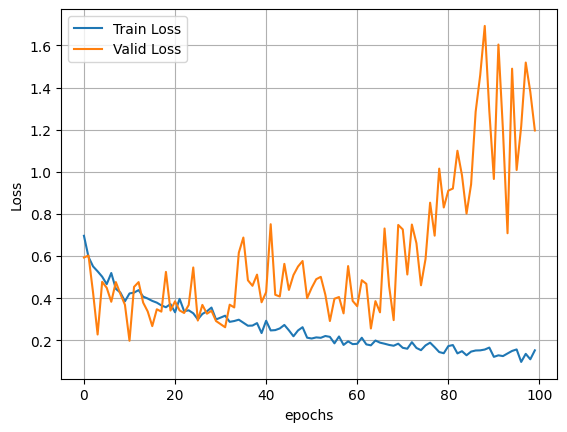

In [62]:
plt.plot( range(history.shape[0]), history["Train Loss"].values, label="Train Loss")
plt.plot( range(history.shape[0]), history["Valid Loss"].values, label="Valid Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

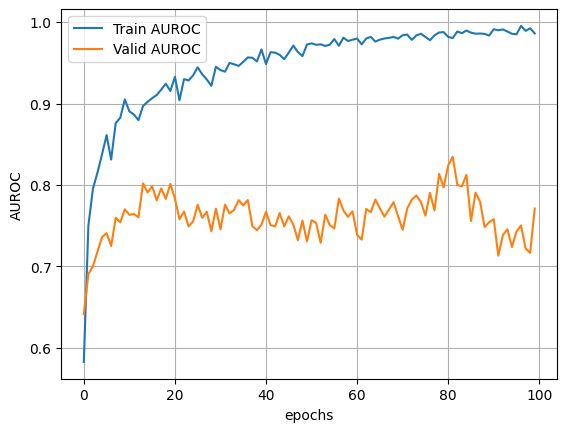

In [63]:
plt.plot( range(history.shape[0]), history["Train AUROC"].values, label="Train AUROC")
plt.plot( range(history.shape[0]), history["Valid AUROC"].values, label="Valid AUROC")
plt.xlabel("epochs")
plt.ylabel("AUROC")
plt.grid()
plt.legend()
plt.show()

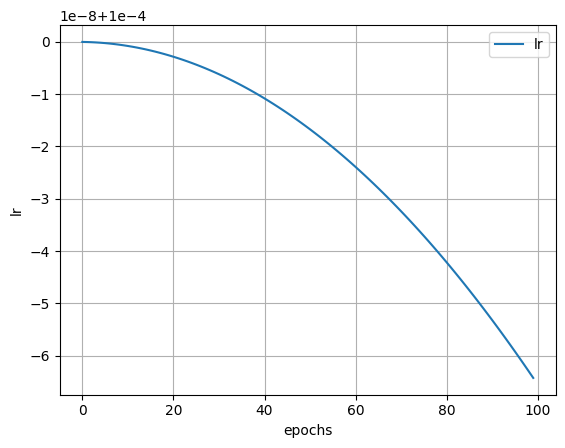

In [64]:
plt.plot( range(history.shape[0]), history["lr"].values, label="lr")
plt.xlabel("epochs")
plt.ylabel("lr")
plt.grid()
plt.legend()
plt.show()

In [65]:
import pickle
file_path = '/kaggle/working/eff_net_2_model.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(model, f)

In [66]:
cols_unique_train=['lesion_id', 'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index', 'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence']

In [67]:
oof_preds=pd.read_csv('/kaggle/input/oof-preds-imagenet21k/v5oof_predictions.csv')

In [68]:
oof=oof_preds['oof_prediction']

In [69]:
df['connect_y']=oof

In [70]:
df=df.drop(cols_unique_train,axis=1)

In [71]:
cat_cols=['sex','anatom_site_general','tbp_tile_type','tbp_lv_location','tbp_lv_location_simple']

In [72]:
obj_but_not_cat=['image_type','copyright_license','attribution','patient_id','file_path','isic_id']

In [73]:
def preprocess(df,cat_labels):
    t=pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv')
    for col in t.columns:
        if((t[col].dtype=='float64' or t[col].dtype=='int64') and t[col].isna().sum()!=0):
            t[col].fillna(value=t[col].mean(),inplace=True);
        if(t[col].dtype=='object' and t[col].isna().sum()!=0):
            t[col].fillna(value=t[col].mode()[0],inplace=True);
    for col in df.columns:
        if((df[col].dtype=='float64' or df[col].dtype=='int64') and df[col].isna().sum()!=0):
            df[col].fillna(value=df[col].mean(),inplace=True);
        if(df[col].dtype=='object' and df[col].isna().sum()!=0):
            df[col].fillna(value=df[col].mode()[0],inplace=True);
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoder.fit(t[cat_labels])
    one_hot_encoded = encoder.transform(df[cat_labels])
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(cat_labels))
    df_encoded = pd.concat([df.drop(columns=cat_labels), one_hot_df], axis=1)
    target=df['target']
    df_f=df_encoded.drop(obj_but_not_cat,axis=1)
    df_f['target']=target
    cat_cols=encoder.get_feature_names_out(cat_labels)
    return df_f,cat_cols

In [74]:
df_f, cat_cols=preprocess(df,cat_cols)
# df_f=df

In [75]:
df_f.columns

Index(['age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext',
       'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H',
       'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
       'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
       'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
       'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
       'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
       'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
       'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
       'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'target', 'kfold', 'connect_y',
       'sex_male', 'anatom_site_general_head/neck',
       'anatom_site_general_lower extremity',
       'anatom_site_general_posterior torso',
       'anatom_site_general_upper extremity', 'tbp_tile_type_3D: white',
       'tbp_lv_location_Left Arm', 'tbp_lv_location_Left Arm 

In [76]:
df_f.shape

(98643, 70)

In [77]:
num_cols = [col for col in df_f.columns if col not in cat_cols and (col!='target' and col!='kfold')]

In [78]:
scaler = StandardScaler()
df_f[num_cols] = scaler.fit_transform(df_f[num_cols],df_f['target'])

In [79]:
CONFIG['device']

device(type='cuda', index=0)

In [80]:
class TabularDataset(Dataset):
    def __init__(self, data, target_column, transform=None):
        self.data = data.drop(columns=[target_column])
        self.targets = data[target_column]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X = self.data.iloc[idx].values.astype(float)
        y = self.targets.iloc[idx].astype(float)
        
        if self.transform:
            X = self.transform(X)
        
        return {'meta':torch.tensor(X, dtype=torch.float32),
                'target':torch.tensor(y, dtype=torch.float32)}


In [81]:
# df_f=df_f.drop(['patient_id','file_path','isic_id'],axis =1)

In [82]:
class MetaModel(nn.Module):
    def __init__(self,in_features):
        super().__init__()
        self.model=nn.Sequential(
                    nn.Linear(in_features,512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Dropout(p=0.7),
#                     nn.Linear(128,128),
#                     nn.BatchNorm1d(128),
#                     nn.ReLU(),
#                     nn.Dropout(p=0.7),
                    nn.Linear(512,128),
                    nn.BatchNorm1d(128),
                    nn.ReLU(),
                    nn.Dropout(p=0.7),
                    nn.Linear(128,1))
    def forward(self,x):
        return self.model(x)
meta_model=MetaModel(df_f.drop(['target','kfold'],axis=1).shape[1])
meta_model=meta_model.to(CONFIG['device'])

In [83]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = TabularDataset(df_train.drop(['kfold'],axis=1),'target')
    valid_dataset = TabularDataset(df_valid.drop(['kfold'],axis=1),'target')

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=4, shuffle=True, pin_memory=False, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=4, shuffle=False, pin_memory=False)
    
    return train_loader, valid_loader

In [84]:
def train_one_epoch_meta(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc  = 0.0
    y_pred=[]
    y_true=[]
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        meta = data['meta'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.int32)
        
        batch_size = meta.size(0)
        
        outputs = model(meta).squeeze()
        loss = criterion(outputs, targets.to(dtype= torch.float32))
        y_pred.append(outputs)
        y_true.append(targets)
#         loss = loss / CONFIG['n_accumulate']
        loss.backward()
#         if (step + 1) % CONFIG['n_accumulate'] == 0:
        optimizer.step()
            # zero the parameter gradients
        optimizer.zero_grad()
        if scheduler is not None:
            scheduler.step()
                
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        
    y_pred = torch.cat(y_pred, dim = 0)
    y_true = torch.cat(y_true, dim = 0)
    epoch_auroc = binary_auroc(input=torch.nn.functional.sigmoid(y_pred), target=y_true).item()
    pauc = pauc_metric(y_true, torch.nn.functional.sigmoid(y_pred))
    print(f'Epoch = {epoch}, Train_Loss = {epoch_loss}, Train_Auroc = {epoch_auroc}, Train_pauc = {pauc}, LR = {optimizer.param_groups[0]["lr"]}') 

    
    return epoch_loss, pauc

In [85]:
@torch.inference_mode()
def valid_one_epoch_meta(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0
    y_pred = [] 
    y_true = []
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        meta = data['meta'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.int32)
        
        batch_size = meta.size(0)

        outputs = model(meta).squeeze()
        y_pred.append(outputs)
        y_true.append(targets)
#             connect_y.append(outputs.ravel())
        loss = criterion(outputs, targets.to(dtype=torch.float32))

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size

    y_pred = torch.cat(y_pred, dim = 0)
    y_true = torch.cat(y_true, dim = 0)
    epoch_auroc = binary_auroc(input=torch.nn.functional.sigmoid(y_pred), target=y_true).item()
    pauc = pauc_metric(y_true, torch.nn.functional.sigmoid(y_pred))
    print(f'Epoch = {epoch}, Valid_Loss = {epoch_loss}, Valid_Auroc = {epoch_auroc}, Valid_pauc = {pauc}, LR = {optimizer.param_groups[0]["lr"]}') 
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, pauc

In [86]:
def run_training(model, optimizer, scheduler, train_loader_meta, valid_loader_meta,device, num_epochs):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_pauc = -np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss, train_epoch_pauc = train_one_epoch_meta(model, optimizer, scheduler, 
                                           dataloader=train_loader_meta, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, val_epoch_pauc = valid_one_epoch_meta(model, valid_loader_meta, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train PAUC'].append(train_epoch_pauc)
        history['Valid PAUC'].append(val_epoch_pauc)
        history['lr'].append( scheduler.get_lr()[0] )
        
        # deep copy the model
        if best_epoch_pauc <= val_epoch_pauc:
            print(f"{b_}Validation PAUC Improved ({best_epoch_pauc} ---> {val_epoch_pauc})")
            best_epoch_pauc = val_epoch_pauc
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "AUROC{:.4f}_Loss{:.4f}_epoch{:.0f}.pkl".format(val_epoch_pauc, val_epoch_loss, epoch)
            torch.save(model.state_dict(), PATH)
            pickle.dump(model,open(PATH,'wb'))
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best AUROC: {:.4f}".format(best_epoch_pauc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [87]:
optimizer2 = optim.Adam(meta_model.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
scheduler2 = fetch_scheduler(optimizer2)

In [88]:
CONFIG['device']

device(type='cuda', index=0)

In [89]:
for f in range(CONFIG['n_fold']):
    print('-------------------------------Fold ',{f},'-------------------------------------------------')
    train_loader_meta, valid_loader_meta = prepare_loaders(df_f, fold=CONFIG["fold"])
    meta_model, history2 = run_training(meta_model, optimizer2, scheduler2,train_loader_meta,
                              valid_loader_meta,
                              device=CONFIG['device'],
                              num_epochs=15)
    torch.cuda.empty_cache()
    

-------------------------------Fold  {0} -------------------------------------------------
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 1, Train_Loss = 0.10393113495845539, Train_Auroc = 0.5106002665697322, Train_pauc = 0.04597535441657578, LR = 9.990228900226787e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 1, Valid_Loss = 0.03896486074554176, Valid_Auroc = 0.8784706726691459, Valid_pauc = 0.14586716252365106, LR = 9.993574748164254e-05
Validation PAUC Improved (-inf ---> 0.14586716252365106)
Model Saved



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 2, Train_Loss = 0.02899405077172498, Train_Auroc = 0.6395137121854679, Train_pauc = 0.06549974554707377, LR = 9.960954176418586e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 2, Valid_Loss = 0.031943424753633244, Valid_Auroc = 0.8691818359757291, Valid_pauc = 0.14724942911202452, LR = 9.993574748164254e-05
Validation PAUC Improved (0.14586716252365106 ---> 0.14724942911202452)
Model Saved



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 3, Train_Loss = 0.027785131103959096, Train_Auroc = 0.7034103154408498, Train_pauc = 0.08082834120925722, LR = 9.912291402816693e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 3, Valid_Loss = 0.02831718146752654, Valid_Auroc = 0.8604208259933451, Valid_pauc = 0.14290663534938342, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 4, Train_Loss = 0.02695488337214241, Train_Auroc = 0.7355292216971606, Train_pauc = 0.09303071206429983, LR = 9.844432696114488e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 4, Valid_Loss = 0.0267634327067946, Valid_Auroc = 0.8804847654465975, Valid_pauc = 0.14773863117374564, LR = 9.993574748164254e-05
Validation PAUC Improved (0.14724942911202452 ---> 0.14773863117374564)
Model Saved



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 5, Train_Loss = 0.02647885258250476, Train_Auroc = 0.7617603295771235, Train_pauc = 0.1052220768205501, LR = 9.757645956996242e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 5, Valid_Loss = 0.022699059068020628, Valid_Auroc = 0.8815997912181118, Valid_pauc = 0.15074887453513405, LR = 9.993574748164254e-05
Validation PAUC Improved (0.14773863117374564 ---> 0.15074887453513405)
Model Saved



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 6, Train_Loss = 0.026308748760294872, Train_Auroc = 0.771315319681732, Train_pauc = 0.10445882305424288, LR = 9.652273812487004e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 6, Valid_Loss = 0.023180195368336935, Valid_Auroc = 0.8823814184119527, Valid_pauc = 0.15143302668493505, LR = 9.993574748164254e-05
Validation PAUC Improved (0.15074887453513405 ---> 0.15143302668493505)
Model Saved



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 7, Train_Loss = 0.025077128775905816, Train_Auroc = 0.8037127509188577, Train_pauc = 0.1184162284421826, LR = 9.528732263288716e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 7, Valid_Loss = 0.021821801262905418, Valid_Auroc = 0.8842160892542572, Valid_pauc = 0.15105565342206562, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 8, Train_Loss = 0.02482314099832557, Train_Auroc = 0.8129821075164586, Train_pauc = 0.12120637747889655, LR = 9.387509041443075e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 8, Valid_Loss = 0.02069850568111989, Valid_Auroc = 0.88747569648333, Valid_pauc = 0.14903751549553074, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 9, Train_Loss = 0.024808925531862994, Train_Auroc = 0.8104295003836989, Train_pauc = 0.11737587947816952, LR = 9.22916168480504e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 9, Valid_Loss = 0.021989248702053318, Valid_Auroc = 0.8892640438441966, Valid_pauc = 0.15334364193906178, LR = 9.993574748164254e-05
Validation PAUC Improved (0.15143302668493505 ---> 0.15334364193906178)
Model Saved



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 10, Train_Loss = 0.024176209534724418, Train_Auroc = 0.8219952340563027, Train_pauc = 0.11741566703017083, LR = 9.054315335928476e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 10, Valid_Loss = 0.020328712476672724, Valid_Auroc = 0.8769491746590983, Valid_pauc = 0.1519163567560514, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 11, Train_Loss = 0.024342004889387075, Train_Auroc = 0.8185631891433418, Train_pauc = 0.12015892806656163, LR = 8.863660274053634e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 11, Valid_Loss = 0.020341551639834556, Valid_Auroc = 0.8882814640829908, Valid_pauc = 0.1538182292686109, LR = 9.993574748164254e-05
Validation PAUC Improved (0.15334364193906178 ---> 0.1538182292686109)
Model Saved



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 12, Train_Loss = 0.023756804691629628, Train_Auroc = 0.8389964861262571, Train_pauc = 0.13664431923744896, LR = 8.657949189940826e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 12, Valid_Loss = 0.021025251938575473, Valid_Auroc = 0.8820075683434462, Valid_pauc = 0.1520382331832713, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 13, Train_Loss = 0.02270814965661617, Train_Auroc = 0.8596825396825397, Train_pauc = 0.14299944262692352, LR = 8.437994214308136e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 13, Valid_Loss = 0.02030611992341565, Valid_Auroc = 0.8924466627520062, Valid_pauc = 0.1562989495661251, LR = 9.993574748164254e-05
Validation PAUC Improved (0.1538182292686109 ---> 0.1562989495661251)
Model Saved



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 14, Train_Loss = 0.02279141891035133, Train_Auroc = 0.8557917524940426, Train_pauc = 0.14251470576356068, LR = 8.20466371160518e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 14, Valid_Loss = 0.01986072544198837, Valid_Auroc = 0.8985998564624519, Valid_pauc = 0.1579632021922098, LR = 9.993574748164254e-05
Validation PAUC Improved (0.1562989495661251 ---> 0.1579632021922098)
Model Saved



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 15, Train_Loss = 0.0228497296226181, Train_Auroc = 0.859152550587665, Train_pauc = 0.14369270164384665, LR = 7.958878851780156e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 15, Valid_Loss = 0.019965145966553244, Valid_Auroc = 0.8912755268480459, Valid_pauc = 0.1581314021008677, LR = 9.993574748164254e-05
Validation PAUC Improved (0.1579632021922098 ---> 0.1581314021008677)
Model Saved

Training complete in 0h 6m 28s
Best AUROC: 0.1581
-------------------------------Fold  {1} -------------------------------------------------
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 1, Train_Loss = 0.023077461988853944, Train_Auroc = 0.8532285633507007, Train_pauc = 0.13603665333818002, LR = 7.701609973575764e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 1, Valid_Loss = 0.019966901200676197, Valid_Auroc = 0.8865214980100476, Valid_pauc = 0.15508390422130877, LR = 9.993574748164254e-05
Validation PAUC Improved (-inf ---> 0.15508390422130877)
Model Saved



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 2, Train_Loss = 0.022052892223628395, Train_Auroc = 0.8687900965305545, Train_pauc = 0.14386234500585643, LR = 7.433872753710209e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 2, Valid_Loss = 0.019517100507518863, Valid_Auroc = 0.9025079924316566, Valid_pauc = 0.15806093821360995, LR = 9.993574748164254e-05
Validation PAUC Improved (0.15508390422130877 ---> 0.15806093821360995)
Model Saved



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 3, Train_Loss = 0.021528807007706815, Train_Auroc = 0.8800631689486651, Train_pauc = 0.1507362979118704, LR = 7.156724197067649e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 3, Valid_Loss = 0.019750142480576802, Valid_Auroc = 0.89980491942324, Valid_pauc = 0.15755855679519798, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 4, Train_Loss = 0.022711487889841963, Train_Auroc = 0.862474817238176, Train_pauc = 0.14345620986308005, LR = 6.871258463728471e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 4, Valid_Loss = 0.019618617000612706, Valid_Auroc = 0.8931826189078097, Valid_pauc = 0.15531571736151883, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 5, Train_Loss = 0.021816831308648983, Train_Auroc = 0.8757507169110222, Train_pauc = 0.15190956419887716, LR = 6.578602549313792e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 5, Valid_Loss = 0.019701786454093234, Valid_Auroc = 0.9042624127356952, Valid_pauc = 0.16142337052260713, LR = 9.993574748164254e-05
Validation PAUC Improved (0.15806093821360995 ---> 0.16142337052260713)
Model Saved



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 6, Train_Loss = 0.021596486172823823, Train_Auroc = 0.8803969465648855, Train_pauc = 0.1496929601357082, LR = 6.279911835697931e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 6, Valid_Loss = 0.019699673425928908, Valid_Auroc = 0.9043387486135578, Valid_pauc = 0.15945808051151558, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 7, Train_Loss = 0.02150302409884036, Train_Auroc = 0.8825299890948746, Train_pauc = 0.15427059251181385, LR = 5.976365529654771e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 7, Valid_Loss = 0.01964667158477788, Valid_Auroc = 0.9025778038755138, Valid_pauc = 0.16081594571670904, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 8, Train_Loss = 0.021388441894109246, Train_Auroc = 0.8780186598812553, Train_pauc = 0.14861688274970714, LR = 5.669162007442674e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 8, Valid_Loss = 0.019635729316473973, Valid_Auroc = 0.9018757747765381, Valid_pauc = 0.1573762641090885, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 9, Train_Loss = 0.021817774026556977, Train_Auroc = 0.8760500827981744, Train_pauc = 0.14889374368916353, LR = 5.359514083715245e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 9, Valid_Loss = 0.01941438395732414, Valid_Auroc = 0.9017948717948718, Valid_pauc = 0.15832165459646372, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 10, Train_Loss = 0.020199456495424258, Train_Auroc = 0.9018210751645866, Train_pauc = 0.1580029565006664, LR = 5.048644223424866e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 10, Valid_Loss = 0.019827428458912624, Valid_Auroc = 0.8954191948848438, Valid_pauc = 0.15918588112481238, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 11, Train_Loss = 0.02105067798803267, Train_Auroc = 0.884312694373763, Train_pauc = 0.15605497798780238, LR = 4.737779715630741e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 11, Valid_Loss = 0.019860045952663514, Valid_Auroc = 0.898868336921772, Valid_pauc = 0.1567113590396033, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 12, Train_Loss = 0.020824445641434316, Train_Auroc = 0.892780887757987, Train_pauc = 0.15554609233006175, LR = 4.428147828260776e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 12, Valid_Loss = 0.019560401825670874, Valid_Auroc = 0.9040979969987604, Valid_pauc = 0.15956912637828669, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 13, Train_Loss = 0.021165160926464775, Train_Auroc = 0.8827859768165112, Train_pauc = 0.15060154287329858, LR = 4.120970962957199e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 13, Valid_Loss = 0.01931559965195737, Valid_Auroc = 0.9062477980035232, Valid_pauc = 0.1618702942519736, LR = 9.993574748164254e-05
Validation PAUC Improved (0.16142337052260713 ---> 0.1618702942519736)
Model Saved



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 14, Train_Loss = 0.021373381089297466, Train_Auroc = 0.8854593481158367, Train_pauc = 0.15163328082717392, LR = 3.817461829133683e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 14, Valid_Loss = 0.019987591330055676, Valid_Auroc = 0.9005082534090167, Valid_pauc = 0.15832583023422714, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 15, Train_Loss = 0.02042885089505787, Train_Auroc = 0.895976089502807, Train_pauc = 0.15718789934973137, LR = 3.51881865629675e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 15, Valid_Loss = 0.01997144615152263, Valid_Auroc = 0.8932788543093887, Valid_pauc = 0.15554485548378674, LR = 9.993574748164254e-05

Training complete in 0h 6m 28s
Best AUROC: 0.1619
-------------------------------Fold  {2} -------------------------------------------------
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 1, Train_Loss = 0.020078044495700106, Train_Auroc = 0.9020731047295932, Train_pauc = 0.15959983844258652, LR = 3.226220463532625e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 1, Valid_Loss = 0.019678883526447047, Valid_Auroc = 0.9046604032100215, Valid_pauc = 0.16177764728909763, LR = 9.993574748164254e-05
Validation PAUC Improved (-inf ---> 0.16177764728909763)
Model Saved



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 2, Train_Loss = 0.020815852703081106, Train_Auroc = 0.8935672684680318, Train_pauc = 0.15677100044428285, LR = 2.9408224048349403e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 2, Valid_Loss = 0.01959729835161424, Valid_Auroc = 0.9020362758530698, Valid_pauc = 0.16384732824427478, LR = 9.993574748164254e-05
Validation PAUC Improved (0.16177764728909763 ---> 0.16384732824427478)
Model Saved



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 3, Train_Loss = 0.020903426587399535, Train_Auroc = 0.8860161557413466, Train_pauc = 0.14888459953956135, LR = 2.663751208651426e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 3, Valid_Loss = 0.01933764815572211, Valid_Auroc = 0.9062347491355125, Valid_pauc = 0.16321772036275847, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 4, Train_Loss = 0.019765389588777913, Train_Auroc = 0.909176137970031, Train_pauc = 0.16388971283169748, LR = 2.3961007296493027e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 4, Valid_Loss = 0.019404016803747644, Valid_Auroc = 0.9083969465648855, Valid_pauc = 0.16359404971618707, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 5, Train_Loss = 0.020620619635142706, Train_Auroc = 0.8902948422795751, Train_pauc = 0.1553583989660325, LR = 2.138927630266831e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 5, Valid_Loss = 0.01907198949862764, Valid_Auroc = 0.9116154498597246, Valid_pauc = 0.16280863835062306, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 6, Train_Loss = 0.020224029368444352, Train_Auroc = 0.8975360878872329, Train_pauc = 0.15902601882143863, LR = 1.8932472090951334e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 6, Valid_Loss = 0.019635274287219562, Valid_Auroc = 0.9025145168656619, Valid_pauc = 0.16194910941475824, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 7, Train_Loss = 0.02069400066221825, Train_Auroc = 0.8959405468718445, Train_pauc = 0.15687277353689563, LR = 1.6600293925615228e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 7, Valid_Loss = 0.019357086895736175, Valid_Auroc = 0.9065857636850003, Valid_pauc = 0.16309584393553853, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 8, Train_Loss = 0.019849356723996403, Train_Auroc = 0.9061656771275092, Train_pauc = 0.1622805606042247, LR = 1.4401949057382656e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 8, Valid_Loss = 0.01947342206792723, Valid_Auroc = 0.9034083643243949, Valid_pauc = 0.16252900110915375, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 9, Train_Loss = 0.019656162934791672, Train_Auroc = 0.907950724988893, Train_pauc = 0.1651176380306151, LR = 1.2346116373951449e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 9, Valid_Loss = 0.019445466172231085, Valid_Auroc = 0.9068734912246362, Valid_pauc = 0.16417341945586217, LR = 9.993574748164254e-05
Validation PAUC Improved (0.16384732824427478 ---> 0.16417341945586217)
Model Saved



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 10, Train_Loss = 0.01955518217237248, Train_Auroc = 0.9085388747526152, Train_pauc = 0.1643580354618522, LR = 1.0440912136437572e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 10, Valid_Loss = 0.01957572791770717, Valid_Auroc = 0.9067071181574998, Valid_pauc = 0.1615383310497814, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 11, Train_Loss = 0.020432074894920427, Train_Auroc = 0.8981175330182963, Train_pauc = 0.16073267902580876, LR = 8.693857937040219e-06


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 11, Valid_Loss = 0.0192926862161525, Valid_Auroc = 0.9031708749266001, Valid_pauc = 0.15943459254909634, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 12, Train_Loss = 0.020236614132187313, Train_Auroc = 0.8980404701320732, Train_pauc = 0.15886579425663394, LR = 7.111851004403511e-06


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 12, Valid_Loss = 0.019420432795476644, Valid_Auroc = 0.9025836758661187, Valid_pauc = 0.16215423761988645, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 13, Train_Loss = 0.019979952758296483, Train_Auroc = 0.9047940546871844, Train_pauc = 0.1633454662950846, LR = 5.7011369739111725e-06


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 13, Valid_Loss = 0.019341916027150304, Valid_Auroc = 0.9045905917661643, Valid_pauc = 0.1622706335225419, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 14, Train_Loss = 0.020120885187415036, Train_Auroc = 0.9047082677006341, Train_pauc = 0.16063970273435918, LR = 4.467285230430861e-06


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 14, Valid_Loss = 0.019560476210623956, Valid_Auroc = 0.9015423761988648, Valid_pauc = 0.16261003457950018, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 15, Train_Loss = 0.019519803134734812, Train_Auroc = 0.9098142897532211, Train_pauc = 0.1613511288824266, LR = 3.4151669208278275e-06


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 15, Valid_Loss = 0.019501645815923556, Valid_Auroc = 0.9062262673713055, Valid_pauc = 0.162489071573041, LR = 9.993574748164254e-05

Training complete in 0h 6m 29s
Best AUROC: 0.1642
-------------------------------Fold  {3} -------------------------------------------------
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 1, Train_Loss = 0.019936366207524262, Train_Auroc = 0.9024517953067571, Train_pauc = 0.1617438830324326, LR = 2.5489357230710326e-06


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 1, Valid_Loss = 0.019437394456126685, Valid_Auroc = 0.9046166895021857, Valid_pauc = 0.15862203953807003, LR = 9.993574748164254e-05
Validation PAUC Improved (-inf ---> 0.15862203953807003)
Model Saved



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 2, Train_Loss = 0.0198396800687197, Train_Auroc = 0.9018133204087403, Train_pauc = 0.16258022941152708, LR = 1.8720114478516172e-06


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 2, Valid_Loss = 0.01939023398497389, Valid_Auroc = 0.9045338291903178, Valid_pauc = 0.1619220982579761, LR = 9.993574748164254e-05
Validation PAUC Improved (0.15862203953807003 ---> 0.1619220982579761)
Model Saved



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 3, Train_Loss = 0.01929038937898641, Train_Auroc = 0.9187230502039663, Train_pauc = 0.1684622965386324, LR = 1.3870665374458242e-06


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 3, Valid_Loss = 0.019633561070624736, Valid_Auroc = 0.9043335290663534, Valid_pauc = 0.16203692829647023, LR = 9.993574748164254e-05
Validation PAUC Improved (0.1619220982579761 ---> 0.16203692829647023)
Model Saved



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 4, Train_Loss = 0.020368737160219256, Train_Auroc = 0.8954417383577689, Train_pauc = 0.15904549860656728, LR = 1.0960155151280219e-06


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 4, Valid_Loss = 0.019862920722628838, Valid_Auroc = 0.8946264761531937, Valid_pauc = 0.1562351406015528, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 5, Train_Loss = 0.02001661475919419, Train_Auroc = 0.9038323034048225, Train_pauc = 0.16381608304051049, LR = 1.0000074267885083e-06


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 5, Valid_Loss = 0.01949145032783301, Valid_Auroc = 0.901118287988517, Valid_pauc = 0.16212892281594568, LR = 9.993574748164254e-05
Validation PAUC Improved (0.16203692829647023 ---> 0.16212892281594568)
Model Saved



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 6, Train_Loss = 0.01988943859718611, Train_Auroc = 0.9019699503210954, Train_pauc = 0.16060311805807986, LR = 1.0994213063967858e-06


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 6, Valid_Loss = 0.019315008252303194, Valid_Auroc = 0.9085528805376134, Valid_pauc = 0.16421674169765768, LR = 9.993574748164254e-05
Validation PAUC Improved (0.16212892281594568 ---> 0.16421674169765768)
Model Saved



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 7, Train_Loss = 0.02008487510717702, Train_Auroc = 0.9026493800234259, Train_pauc = 0.16071161597802816, LR = 1.3938646777410609e-06


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 7, Valid_Loss = 0.01924344852554634, Valid_Auroc = 0.9101363606707118, Valid_pauc = 0.16055601226593588, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 8, Train_Loss = 0.01973690427558878, Train_Auroc = 0.9090462458096046, Train_pauc = 0.16380491942324002, LR = 1.8821751022116473e-06


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 8, Valid_Loss = 0.019970230129755132, Valid_Auroc = 0.8970561753767861, Valid_pauc = 0.15975037515495527, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 9, Train_Loss = 0.020394140890190236, Train_Auroc = 0.8954901248031019, Train_pauc = 0.15729363059897405, LR = 2.5624247697569067e-06


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 9, Valid_Loss = 0.019497229464636136, Valid_Auroc = 0.9027676649050694, Valid_pauc = 0.16128740131793565, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 10, Train_Loss = 0.02017261177416609, Train_Auroc = 0.9007407407407407, Train_pauc = 0.158232537663072, LR = 3.431928109722045e-06


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 10, Valid_Loss = 0.019444811784051243, Valid_Auroc = 0.903587786259542, Valid_pauc = 0.15838702942519733, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 11, Train_Loss = 0.020683971933653726, Train_Auroc = 0.8909309745950967, Train_pauc = 0.15536788238620297, LR = 4.487252393263689e-06


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 11, Valid_Loss = 0.019704336135830225, Valid_Auroc = 0.9025314803940758, Valid_pauc = 0.16137274091472562, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 12, Train_Loss = 0.020804238826960548, Train_Auroc = 0.8877920756088695, Train_pauc = 0.1538304899228563, LR = 5.72423128548461e-06


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 12, Valid_Loss = 0.019970996572733504, Valid_Auroc = 0.9001415802179161, Valid_pauc = 0.1572327265609708, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 13, Train_Loss = 0.020336454974935057, Train_Auroc = 0.8979622763439558, Train_pauc = 0.16011989175653293, LR = 7.137981293789747e-06


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 13, Valid_Loss = 0.019704217851065273, Valid_Auroc = 0.9003829842761141, Valid_pauc = 0.16036001826841517, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 14, Train_Loss = 0.020171214585098005, Train_Auroc = 0.899231229048023, Train_pauc = 0.1529843652813118, LR = 8.722921047519993e-06


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 14, Valid_Loss = 0.019704652740185763, Valid_Auroc = 0.9011137208847132, Valid_pauc = 0.15530945390487372, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 15, Train_Loss = 0.01981144206708333, Train_Auroc = 0.9058606567308858, Train_pauc = 0.1647804838644533, LR = 1.0472793332746195e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 15, Valid_Loss = 0.019337876458914417, Valid_Auroc = 0.9036334572975795, Valid_pauc = 0.16318000913420758, LR = 9.993574748164254e-05

Training complete in 0h 6m 27s
Best AUROC: 0.1642
-------------------------------Fold  {4} -------------------------------------------------
[INFO] Using GPU: Tesla P100-PCIE-16GB



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 1, Train_Loss = 0.019992154828723994, Train_Auroc = 0.9040807787067329, Train_pauc = 0.1595165152065915, LR = 1.2380689795251707e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 1, Valid_Loss = 0.019473944025511482, Valid_Auroc = 0.909001109153781, Valid_pauc = 0.16409773602140007, LR = 9.993574748164254e-05
Validation PAUC Improved (-inf ---> 0.16409773602140007)
Model Saved



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 2, Train_Loss = 0.020336939133989398, Train_Auroc = 0.8977188093218628, Train_pauc = 0.16001740781130092, LR = 1.4439078214150839e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 2, Valid_Loss = 0.019812523025569156, Valid_Auroc = 0.9009545246949827, Valid_pauc = 0.1603062569322111, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 3, Train_Loss = 0.020532831000351207, Train_Auroc = 0.8941840946726443, Train_pauc = 0.15874958600912797, LR = 1.6639832238486677e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 3, Valid_Loss = 0.019347817140774135, Valid_Auroc = 0.9090950610034579, Valid_pauc = 0.16323611926665357, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 4, Train_Loss = 0.019819319196085112, Train_Auroc = 0.9069710408336362, Train_pauc = 0.1601206268427642, LR = 1.8974263469415493e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 4, Valid_Loss = 0.019228819265224444, Valid_Auroc = 0.9044307431330332, Valid_pauc = 0.16072290728779276, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 5, Train_Loss = 0.02036275620440268, Train_Auroc = 0.8984868532654792, Train_pauc = 0.15835071691102223, LR = 2.1433155761290333e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 5, Valid_Loss = 0.019114876085921023, Valid_Auroc = 0.9085489658772101, Valid_pauc = 0.15914529914529912, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 6, Train_Loss = 0.020136863495138522, Train_Auroc = 0.8978031422916919, Train_pauc = 0.15588293145926732, LR = 2.4006801606266778e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 6, Valid_Loss = 0.019343113479871433, Valid_Auroc = 0.9027960461929928, Valid_pauc = 0.1603261564559274, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 7, Train_Loss = 0.019943355059277506, Train_Auroc = 0.9027142453249324, Train_pauc = 0.15842530796881937, LR = 2.6685040458756106e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 7, Valid_Loss = 0.020447158670870155, Valid_Auroc = 0.8977047041169178, Valid_pauc = 0.15603679780779012, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 8, Train_Loss = 0.01992896778731717, Train_Auroc = 0.9026089098913527, Train_pauc = 0.1608189264509875, LR = 2.9457298848437414e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 8, Valid_Loss = 0.01931733752254152, Valid_Auroc = 0.9067188621387094, Valid_pauc = 0.16134037972205909, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 9, Train_Loss = 0.020623865706426808, Train_Auroc = 0.8959789975362494, Train_pauc = 0.15673104729593276, LR = 3.231263212345996e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 9, Valid_Loss = 0.0191688345441563, Valid_Auroc = 0.9067482220917336, Valid_pauc = 0.15935421152215043, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 10, Train_Loss = 0.019644757429849342, Train_Auroc = 0.908725231229048, Train_pauc = 0.16500860293226702, LR = 3.5239767659055415e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 10, Valid_Loss = 0.020043171706570904, Valid_Auroc = 0.8988986755398969, Valid_pauc = 0.15723624975533368, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 11, Train_Loss = 0.020063488134340245, Train_Auroc = 0.9049439799668807, Train_pauc = 0.16030128842037236, LR = 3.8227149360930916e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 11, Valid_Loss = 0.019820329246004714, Valid_Auroc = 0.9052997977425459, Valid_pauc = 0.15995080576759965, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 12, Train_Loss = 0.01999564709820796, Train_Auroc = 0.9040452360757705, Train_pauc = 0.16120333616058802, LR = 4.1262983287805595e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 12, Valid_Loss = 0.019665682221561162, Valid_Auroc = 0.9075722581066092, Valid_pauc = 0.15932289423892476, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 13, Train_Loss = 0.01988075293873412, Train_Auroc = 0.903311684639929, Train_pauc = 0.1605141685851609, LR = 4.433528421293508e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 13, Valid_Loss = 0.019610330335560217, Valid_Auroc = 0.9053917922620213, Valid_pauc = 0.16052913159783386, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 14, Train_Loss = 0.020255145816335297, Train_Auroc = 0.8988973706530958, Train_pauc = 0.15935394805929154, LR = 4.7431922940814385e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 14, Valid_Loss = 0.019922020848891837, Valid_Auroc = 0.9025804136491159, Valid_pauc = 0.16108201213544723, LR = 9.993574748164254e-05



  0%|          | 0/4933 [00:00<?, ?it/s]

Epoch = 15, Train_Loss = 0.019676418634661325, Train_Auroc = 0.9095079768972899, Train_pauc = 0.1608711498848903, LR = 5.054067419226327e-05


  0%|          | 0/617 [00:00<?, ?it/s]

Epoch = 15, Valid_Loss = 0.01925222353899469, Valid_Auroc = 0.9055823057349774, Valid_pauc = 0.1628526130358191, LR = 9.993574748164254e-05

Training complete in 0h 6m 27s
Best AUROC: 0.1641


In [90]:
import pickle
file_path = '/kaggle/working/meta_model_8_model.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(meta_model, f)

In [91]:
df_train=df_f

In [92]:
def comp_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80):
    v_gt = abs(np.asarray(solution.values)-1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

def custom_lgbm_metric(y_true, y_hat):
    # TODO: Refactor with the above.
    min_tpr = 0.80
    v_gt = abs(y_true-1)
    v_pred = np.array([1.0 - x for x in y_hat])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return "pauc80", partial_auc, True

In [93]:
N_SPLITS=5

In [94]:
df_train.columns = df_train.columns.str.replace(r'[^\w\s]', '_', regex=True)

In [95]:
train_cols=df_train.drop(['kfold','target'],axis=1).columns

In [96]:
def objective(trial):
    param = {
        "objective":         "binary",
        # "metric":           "custom",
        "verbosity":         -1,
        "boosting_type":     "gbdt",
        "lambda_l1":         trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2":         trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves":        trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction":  trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction":  trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq":      trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "device":            "gpu"
    }
    
    scores = []
    
    for fold in range(N_SPLITS):
        _df_train = df_train[df_train["kfold"] != fold].reset_index(drop=True)
        _df_valid = df_train[df_train["kfold"] == fold].reset_index(drop=True)
        dtrain = lgb.Dataset(_df_train[train_cols], label=_df_train["target"])
        gbm = lgb.train(param, dtrain)
        preds = gbm.predict(_df_valid[train_cols])
        score = comp_score(_df_valid[["target"]], pd.DataFrame(preds, columns=["prediction"]), "")
        scores.append(score)
        
    return np.mean(scores)

In [97]:
OPTIMIZE_OPTUNA= False

In [98]:
if OPTIMIZE_OPTUNA:
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=21)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [99]:
def comp_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80):
    v_gt = abs(np.asarray(solution.values)-1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

def custom_lgbm_metric(y_true, y_hat):
    # TODO: Refactor with the above.
    min_tpr = 0.80
    v_gt = abs(y_true-1)
    v_pred = np.array([1.0 - x for x in y_hat])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return "pauc80", partial_auc, True

In [100]:
new_params_original = {
    "objective": "binary",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "n_estimators": 200,
    'learning_rate': 0.05,    
    'lambda_l1': 4.463745456817233e-06,
    'lambda_l2': 7.824473303015684,
    'num_leaves': 71,
    'feature_fraction': 0.595173790329758,
    'bagging_fraction': 0.9255422935941319,
    'bagging_freq': 2,
    'min_child_samples': 6,
    "device": "gpu"
}
lgb_scores = []
lgb_models = []
oof_df = pd.DataFrame()
for fold in range(5):
    _df_train = df_train[df_train["kfold"] != fold].reset_index(drop=True)
    _df_valid = df_train[df_train["kfold"] == fold].reset_index(drop=True)
    # model = lgb.LGBMClassifier(**new_params)
    model = VotingClassifier([(f"lgb_{i}", lgb.LGBMClassifier(random_state=i, **new_params_original)) for i in range(7)], voting="soft")
    model.fit(_df_train[train_cols], _df_train["target"])
    preds = model.predict_proba(_df_valid[train_cols])[:, 1]
    score = comp_score(_df_valid[["target"]], pd.DataFrame(preds, columns=["prediction"]), "")
    print(f"fold: {fold} - Partial AUC Score: {score:.5f}")
    lgb_models.append(model)
    oof_single = _df_valid[[ "target"]].copy()
    oof_single["pred"] = preds
    oof_df = pd.concat([oof_df, oof_single])

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


fold: 0 - Partial AUC Score: 0.14527
fold: 1 - Partial AUC Score: 0.14489
fold: 2 - Partial AUC Score: 0.16232
fold: 3 - Partial AUC Score: 0.16128
fold: 4 - Partial AUC Score: 0.17972


In [101]:
lgbm_score = comp_score(oof_df["target"], oof_df["pred"], "")
print(f"LGBM Score: {lgbm_score:.5f}")

LGBM Score: 0.15707


In [102]:
import pickle
file_path = '/kaggle/working/lgbm_11.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(lgb_models, f)

In [103]:
from IPython.display import FileLink

FileLink(r'/kaggle/working/AUROC0.8315_Loss8.5594_epoch1.pkl')

/kaggle/working/AUROC0.8315_Loss8.5594_epoch1.pkl

In [104]:
!ls /kaggle/working/

AUROC0.1459_Loss0.0390_epoch1.pkl   AUROC0.1641_Loss0.0195_epoch1.pkl
AUROC0.1472_Loss0.0319_epoch2.pkl   AUROC0.1642_Loss0.0193_epoch6.pkl
AUROC0.1477_Loss0.0268_epoch4.pkl   AUROC0.1642_Loss0.0194_epoch9.pkl
AUROC0.1507_Loss0.0227_epoch5.pkl   AUROC0.6413_Loss0.5931_epoch1.pkl
AUROC0.1514_Loss0.0232_epoch6.pkl   AUROC0.6907_Loss0.6026_epoch2.pkl
AUROC0.1533_Loss0.0220_epoch9.pkl   AUROC0.7001_Loss0.4263_epoch3.pkl
AUROC0.1538_Loss0.0203_epoch11.pkl  AUROC0.7181_Loss0.2274_epoch4.pkl
AUROC0.1551_Loss0.0200_epoch1.pkl   AUROC0.7362_Loss0.4775_epoch5.pkl
AUROC0.1563_Loss0.0203_epoch13.pkl  AUROC0.7408_Loss0.4492_epoch6.pkl
AUROC0.1580_Loss0.0199_epoch14.pkl  AUROC0.7599_Loss0.4764_epoch8.pkl
AUROC0.1581_Loss0.0195_epoch2.pkl   AUROC0.7702_Loss0.3685_epoch10.pkl
AUROC0.1581_Loss0.0200_epoch15.pkl  AUROC0.8019_Loss0.3788_epoch14.pkl
AUROC0.1586_Loss0.0194_epoch1.pkl   AUROC0.8136_Loss1.0151_epoch79.pkl
AUROC0.1614_Loss0.0197_epoch5.pkl   AUROC0.8240_Loss0.9107_epoch81.pkl
AUROC0.1618_Loss